# Image Classification on Oxford IIIT Pet Image dataset

## Imports

In [1]:
import os
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LeakyReLU, BatchNormalization

In [2]:
tf.__version__

'2.3.0'

In [3]:
tf.get_logger().setLevel('ERROR')

### Check for GPU

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Constants

In [5]:
BASE_PATH = "Oxford-IIIT Pet\images"
TB_LOGS = "tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
IMAGE_SIZE = (256, 256)
RANDOM_STATE = 7
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 0.8, 0.1, 0.1
BATCH_SIZE = 32
EPOCHS = 200
LEARNING_RATE = 0.0001
PLOTS_DPI = 300

## Data loading

### Get all image filenames

In [6]:
imageNames = [os.path.basename(file) for file in glob.glob(os.path.join(BASE_PATH, '*.jpg'))]

print(f"\nTotal number of image files: {len(imageNames)}")


Total number of image files: 7390


### Get target label from filenames

In [7]:
labels = [' '.join(name.split('_')[:-1]) for name in imageNames ]

print(f"\nTotal number of unique labels: {len(np.unique(labels))}")


Total number of unique labels: 37


### Lookup dictionary for Label Encoding

In [8]:
labelEncDict = {name : ind for ind, name in enumerate(np.unique(labels))}
for k, v in labelEncDict.items():
    print(f"{k:32} : {v}")

Abyssinian                       : 0
Bengal                           : 1
Birman                           : 2
Bombay                           : 3
British Shorthair                : 4
Egyptian Mau                     : 5
Maine Coon                       : 6
Persian                          : 7
Ragdoll                          : 8
Russian Blue                     : 9
Siamese                          : 10
Sphynx                           : 11
american bulldog                 : 12
american pit bull terrier        : 13
basset hound                     : 14
beagle                           : 15
boxer                            : 16
chihuahua                        : 17
english cocker spaniel           : 18
english setter                   : 19
german shorthaired               : 20
great pyrenees                   : 21
havanese                         : 22
japanese chin                    : 23
keeshond                         : 24
leonberger                       : 25
miniature pinscher    

### Reverse lookup dictionary for Label Encoding

In [9]:
labelDecDict = {ind: name for name, ind in labelEncDict.items()}
for k, v in labelDecDict.items():
    print(f"{k:3} : {v}")

  0 : Abyssinian
  1 : Bengal
  2 : Birman
  3 : Bombay
  4 : British Shorthair
  5 : Egyptian Mau
  6 : Maine Coon
  7 : Persian
  8 : Ragdoll
  9 : Russian Blue
 10 : Siamese
 11 : Sphynx
 12 : american bulldog
 13 : american pit bull terrier
 14 : basset hound
 15 : beagle
 16 : boxer
 17 : chihuahua
 18 : english cocker spaniel
 19 : english setter
 20 : german shorthaired
 21 : great pyrenees
 22 : havanese
 23 : japanese chin
 24 : keeshond
 25 : leonberger
 26 : miniature pinscher
 27 : newfoundland
 28 : pomeranian
 29 : pug
 30 : saint bernard
 31 : samoyed
 32 : scottish terrier
 33 : shiba inu
 34 : staffordshire bull terrier
 35 : wheaten terrier
 36 : yorkshire terrier


### Class distribution

Since all classes have almost similar number of datapoints, each class will be given equal weight.

In [10]:
for i in labelEncDict.keys():
    print(f"{i:32} : {labels.count(i)}")

Abyssinian                       : 200
Bengal                           : 200
Birman                           : 200
Bombay                           : 200
British Shorthair                : 200
Egyptian Mau                     : 200
Maine Coon                       : 200
Persian                          : 200
Ragdoll                          : 200
Russian Blue                     : 200
Siamese                          : 200
Sphynx                           : 200
american bulldog                 : 200
american pit bull terrier        : 200
basset hound                     : 200
beagle                           : 200
boxer                            : 200
chihuahua                        : 200
english cocker spaniel           : 200
english setter                   : 200
german shorthaired               : 200
great pyrenees                   : 200
havanese                         : 200
japanese chin                    : 200
keeshond                         : 200
leonberger               

### Load image data into a numpy array

In [11]:
%%time

imageData = []

for name in tqdm(imageNames, desc = 'Loading image data', unit = ' images'):
    img = load_img(os.path.join(BASE_PATH, name))
    img = tf.image.resize_with_pad(img_to_array(img, dtype = 'uint8'), *IMAGE_SIZE).numpy().astype('uint8')
    imageData.append(img)
    
imageData = np.array(imageData)
imageData.shape

Loading image data: 100%|██████████| 7390/7390 [01:46<00:00, 69.21 images/s]
Wall time: 1min 47s


(7390, 256, 256, 3)

In [12]:
labelsEncoded = list(map(lambda x : labelEncDict.get(x), labels))

for i, l in zip(imageNames[::1000], labelsEncoded[::1000]):
    print(f"{i:32}\t{labelDecDict[l]:32}\t{l}")

Abyssinian_1.jpg                	Abyssinian                      	0
Bengal_1.jpg                    	Bengal                          	1
chihuahua_1.jpg                 	chihuahua                       	17
great_pyrenees_1.jpg            	great pyrenees                  	21
Maine_Coon_1.jpg                	Maine Coon                      	6
pug_1.jpg                       	pug                             	29
scottish_terrier_1.jpg          	scottish terrier                	32
wheaten_terrier_108.jpg         	wheaten terrier                 	35


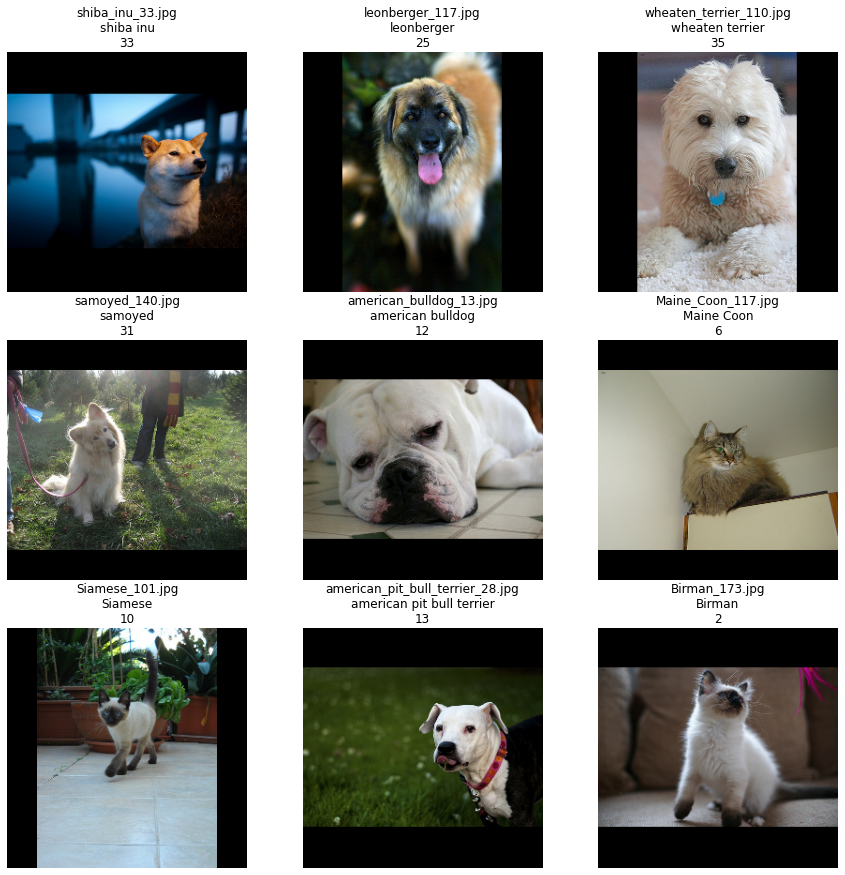

In [13]:
plt.subplots(nrows = 3, ncols = 3, figsize = (15, 15))

for i, imgIndex in enumerate(np.random.randint(0, len(imageNames), size = 9)):
  plt.subplot(3, 3, i + 1)
  plt.axis(False)
  plt.grid(False)
  plt.title(f'{imageNames[imgIndex]}\n{labels[imgIndex]}\n{labelsEncoded[imgIndex]}')
  plt.imshow(imageData[imgIndex])
plt.show()

## Train, Validation and Test data preparation

### Split data and labels into 3 sets

In [14]:
imageData.max()

255

In [15]:
X_tv, X_test, y_tv, y_test = train_test_split(
    imageData, 
    labelsEncoded, 
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE, 
    stratify = labelsEncoded
    )

X_train, X_val, y_train, y_val = train_test_split(
    X_tv, 
    y_tv, 
    test_size = VAL_SIZE, 
    random_state = RANDOM_STATE, 
    stratify = y_tv
    )

print(f'Training Data: {X_train.shape}')
print(f'Training Labels: {len(y_train)}')
print(f'\nValidation Data: {X_val.shape}')
print(f'Validation Labels: {len(y_val)}')
print(f'\nTesting Data: {X_test.shape}')
print(f'Testing Labels: {len(y_test)}')

Training Data: (5985, 256, 256, 3)
Training Labels: 5985

Validation Data: (666, 256, 256, 3)
Validation Labels: 666

Testing Data: (739, 256, 256, 3)
Testing Labels: 739


### Delete variables no more required to reduce memory footprint

In [16]:
del imageData
del labelsEncoded
del X_tv
del y_tv

### Image Data Generator for training data using Image augmentation

In [17]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')
train_data = train_gen.flow(x = X_train, y = y_train, batch_size = BATCH_SIZE, shuffle = True)
len(train_data)

188

### Image Data Generator for validation data

In [18]:
val_gen = ImageDataGenerator(rescale = 1./255)
val_data = val_gen.flow(x = X_val, y = y_val, batch_size = BATCH_SIZE, shuffle = True)
len(val_data)

21

### Image Data Generator for testing data

In [19]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_data = test_gen.flow(x = X_test, y = y_test, batch_size = BATCH_SIZE)
len(test_data)

24

### Visualize images from generators

In [20]:
def plot_generator_images(gen, suptitle, labelDecDict, print_pred = False, model = None, nrows = 3, ncols = 3, figsize = (12, 12)):
    gen_data = gen.next()
    
    plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    plt.suptitle(suptitle, fontsize = 20)
    plt.tight_layout(rect = [0, 0, 1, 0.96], h_pad = 2)
    
    if(print_pred and model):
        pred = np.argmax(model.predict(gen_data[0]), axis=1)

    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i + 1)
        plt.axis(False)
        plt.grid(False)
        
        if(print_pred and pred.any()):
            plt.title(f"True: {labelDecDict[gen_data[1][i]]}\nPredicted: {labelDecDict[pred[i]]}")
        else:
            plt.title(labelDecDict[gen_data[1][i]])
        plt.imshow(gen_data[0][i])

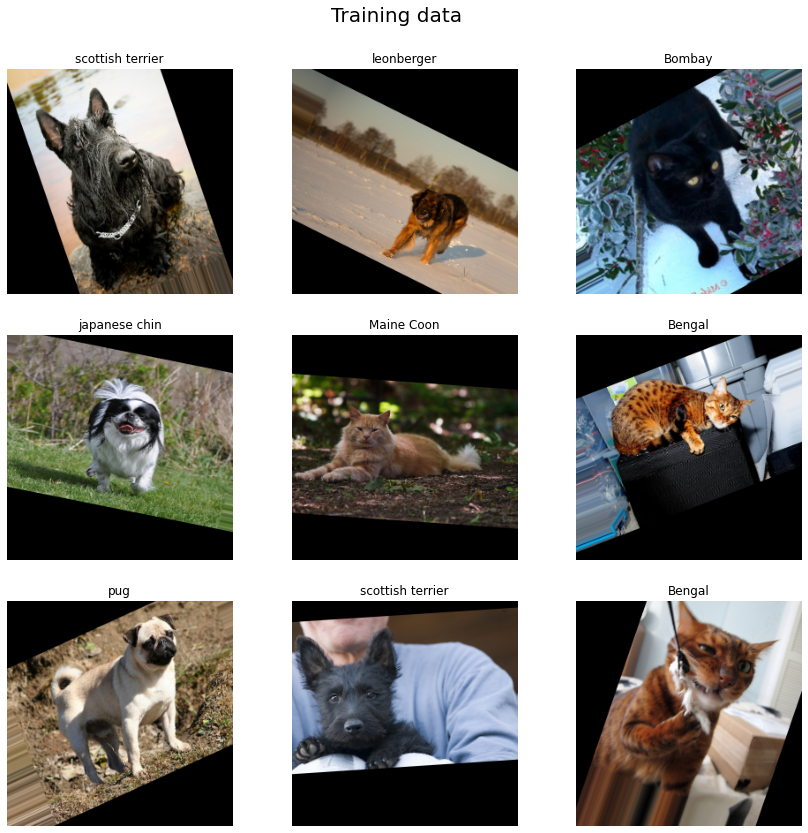

In [21]:
plot_generator_images(train_data, "Training data", labelDecDict)

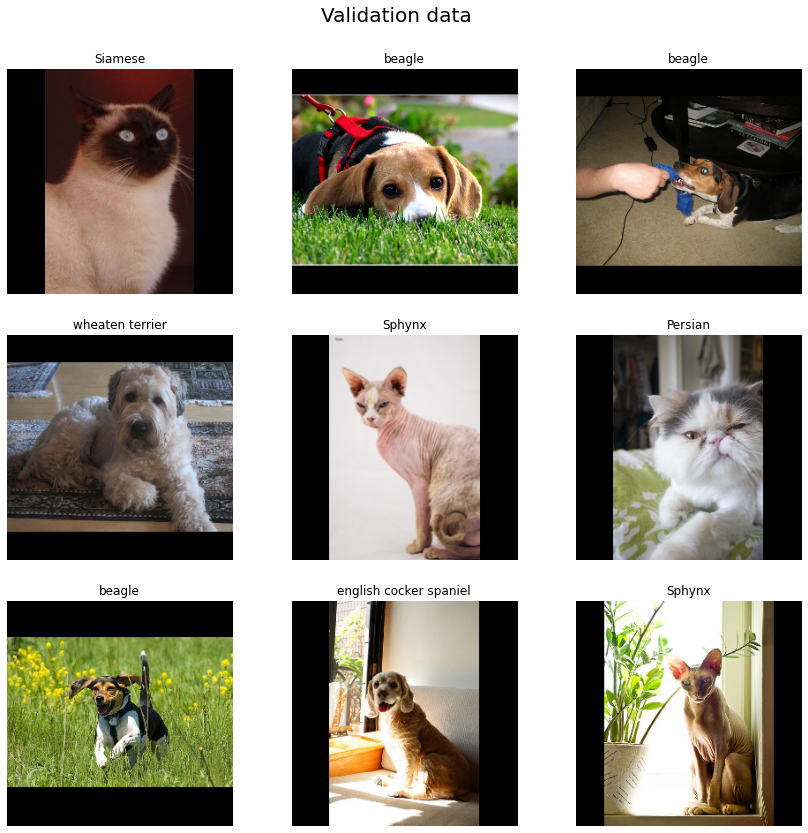

In [22]:
plot_generator_images(val_data, "Validation data", labelDecDict)

## CNN Model

### Model creation

In [23]:
model = Sequential([
    Conv2D(16, 5, padding = 'same', input_shape = (*IMAGE_SIZE, 3)),
    Conv2D(16, 5, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    Conv2D(32, 4, padding = 'same'),
    Conv2D(32, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    Conv2D(64, 4, padding = 'same'),
    Conv2D(64, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(128, 3, padding = 'same'),
    Conv2D(128, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    Conv2D(128, 3, padding = 'same'),
    Conv2D(128, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    Conv2D(256, 2, padding = 'same'),
    Conv2D(256, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    Flatten(),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1024, activation = 'sigmoid'),
    Dropout(0.2),
    Dense(512, activation = 'sigmoid'),
    Dropout(0.1),
    Dense(len(labelEncDict), activation = 'softmax')
])

model.compile(optimizer = Adam(LEARNING_RATE), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['sparse_categorical_accuracy'])
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      6416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      8224      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        3

### Model training

In [24]:
%%time

earlyStop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
tensorBoard = TensorBoard(log_dir = TB_LOGS, histogram_freq = 20)

history = model.fit(train_data, validation_data = val_data, epochs = EPOCHS, verbose = 1, callbacks = [earlyStop, tensorBoard])

Epoch 1/200
188/188 [==============================] - 74s 396ms/step - loss: 3.5275 - sparse_categorical_accuracy: 0.0600 - val_loss: 3.5916 - val_sparse_categorical_accuracy: 0.0315
Epoch 2/200
188/188 [==============================] - 76s 406ms/step - loss: 3.3074 - sparse_categorical_accuracy: 0.1026 - val_loss: 3.5300 - val_sparse_categorical_accuracy: 0.0375
Epoch 3/200
188/188 [==============================] - 78s 414ms/step - loss: 3.1693 - sparse_categorical_accuracy: 0.1333 - val_loss: 3.2573 - val_sparse_categorical_accuracy: 0.1201
Epoch 4/200
188/188 [==============================] - 83s 443ms/step - loss: 3.0623 - sparse_categorical_accuracy: 0.1594 - val_loss: 3.0878 - val_sparse_categorical_accuracy: 0.1441
Epoch 5/200
188/188 [==============================] - 78s 418ms/step - loss: 2.9723 - sparse_categorical_accuracy: 0.1719 - val_loss: 3.2228 - val_sparse_categorical_accuracy: 0.1336
Epoch 6/200
188/188 [==============================] - 78s 414ms/step - loss: 2.

### Training results

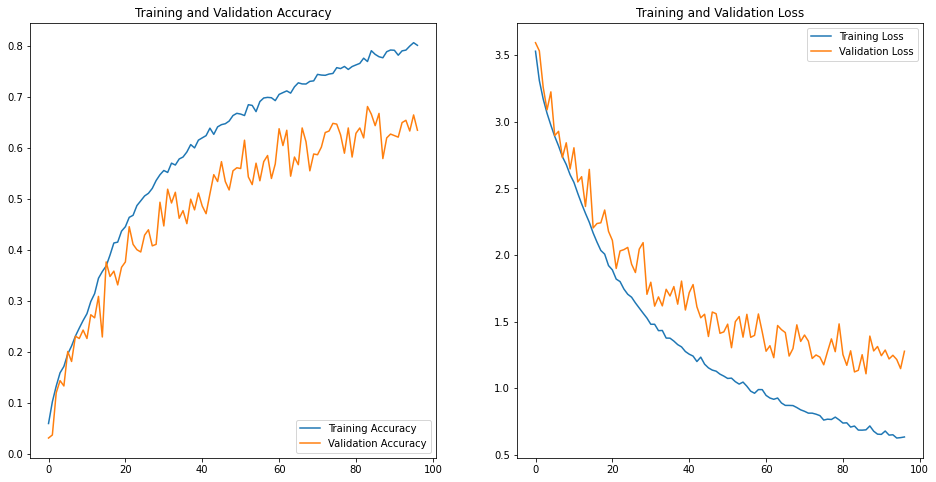

In [25]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('plots/acc_and_loss.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

## Model Evaluation on testing data

In [26]:
test_loss, test_acc = model.evaluate(test_data, verbose = 0)

print(f"Loss on Testing data: {test_loss}")
print(f"Accuracy on Testing data: {test_acc}")

Loss on Testing data: 1.1318687200546265
Accuracy on Testing data: 0.6481732130050659


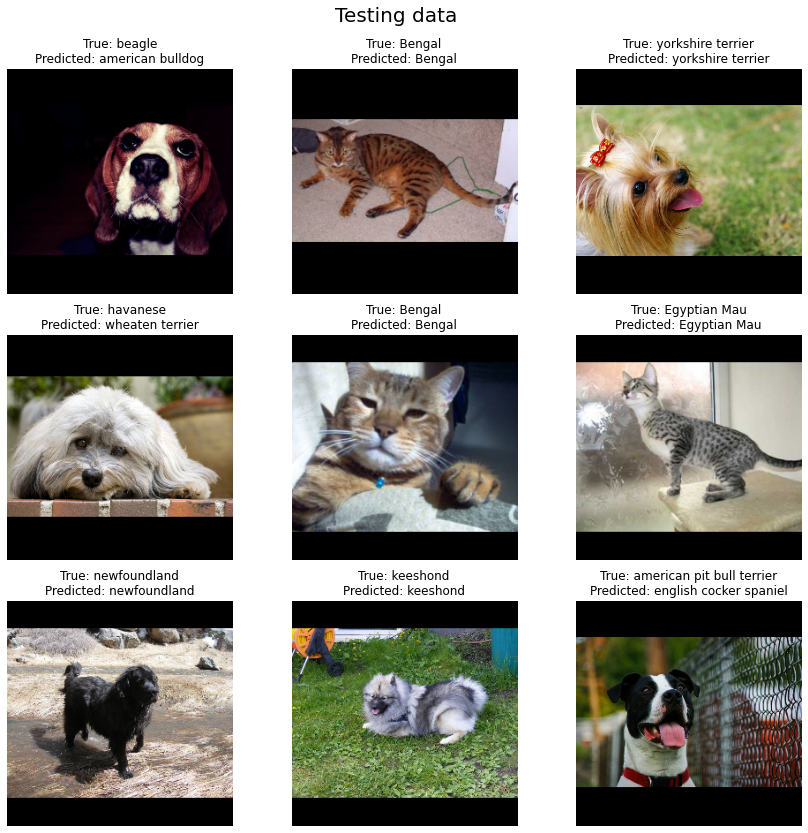

In [27]:
plot_generator_images(test_data, "Testing data", labelDecDict, print_pred = True, model = model)

### Confusion Matrix

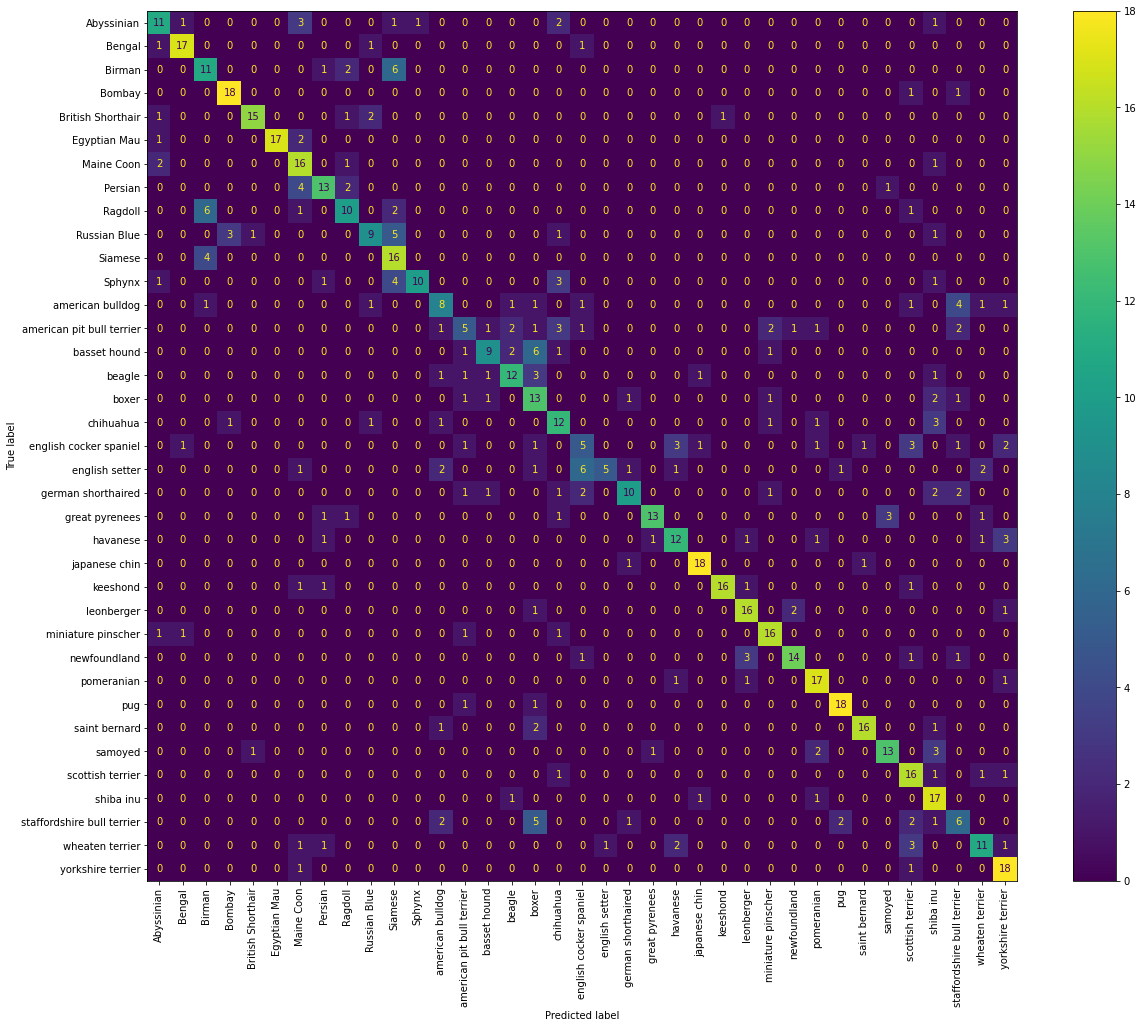

In [28]:
y_pred = np.argmax(model.predict(X_test/255), axis = 1)

_, ax = plt.subplots(figsize = (20, 16))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels = list(labelEncDict.values())),
                        display_labels = list(labelEncDict.keys())
                        ).plot(ax = ax, xticks_rotation = 'vertical')
                        
plt.savefig('plots/confusion_matrix.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

## Saving and loading the model

### Save the trained model

In [29]:
model.save('models/pet_image_classifier')

### Load the saved model

In [30]:
saved_model = tf.keras.models.load_model('models/pet_image_classifier')

sm_test_loss, sm_test_acc = saved_model.evaluate(test_data, verbose = 0)

print(f"Loss on Testing data: {sm_test_loss}")
print(f"Accuracy on Testing data: {sm_test_acc}")

Loss on Testing data: 1.131868600845337
Accuracy on Testing data: 0.6481732130050659
